In [32]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [33]:
df = pd.read_csv('data.csv')

print(df.shape)
df.head()


(4777, 443)


,0.0,0.0.1,0.0.2,0.0.3,0.0.4,0.0.5,0.0.6,0.0.7,0.0.8,0.0.9,...,0.0.428,0.0.429,0.0.430,0.0.431,0.0.432,0.0.433,0.0.434,0.0.435,0.0.436,0.0.437
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,3.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0


In [34]:
df = torch.tensor(df.values)

mask = df != 0
train_mask = np.random.choice([1, 0], size=df.shape, p=[2/3, 1/3])
test_mask = 1-train_mask

train_mask = torch.tensor(train_mask)
test_mask = torch.tensor(test_mask)

train_mask = train_mask * mask
test_mask = test_mask * mask

train = df * train_mask
test = df * test_mask


In [35]:


# normalize 
train_mean = torch.sum(train[train != 0]) / torch.sum(train != 0)
print('train_mean: ', train_mean)
train_std = torch.std(train[train_mask])
print('train_std: ', train_std)
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# print the non-zero values of the train and test
print(df[mask].shape)
print(train[train_mask].shape)
print(test[test_mask].shape)

# print the min and max in the train and test
print("Minimum value in train: ", torch.min(train).item())
print("Maximum value in train: ", torch.max(train).item())

print("Minimum value in test: ", torch.min(test).item())
print("Maximum value in test: ", torch.max(test).item())

train_mean:  tensor(3.4752, dtype=torch.float64)
train_std:  tensor(0.3766, dtype=torch.float64)
torch.Size([39248])
torch.Size([4777, 443, 443])
torch.Size([4777, 443, 443])
Minimum value in train:  -9.227260802687343
Maximum value in train:  4.048609948603631
Minimum value in test:  -9.227260802687343
Maximum value in test:  4.048609948603631


## First model
Measure the similarity between users and movies.

In [36]:
num_users = df.shape[1]
num_features = 10  #the size of vectors for users and movies
num_movies = df.shape[0]


class Model(nn.Module):
    def __init__(self, num_users, num_movies, num_features):
        super().__init__()
        self.W = nn.Parameter(torch.randn(num_users, num_features)) # the weight matrix for users
        self.b_users = nn.Parameter(torch.randn(num_users, 1)) # the bias for users
        self.X = nn.Parameter(torch.randn(num_movies, num_features)) # the weight matrix for movies

    def forward(self, indices=None):
        if indices is None:
            return torch.matmul(self.W, self.X.T) + self.b_users  # the predicted rating for all users and movies
        else:
            return torch.matmul(self.W[indices], self.X.T) + self.b_users[indices] # the predicted rating for the users and movies in the indices


model = Model(num_users, num_movies, num_features)

# get the count of model parameters
print('The number of parameters in the model is: ', sum(p.numel() for p in model.parameters()))
print("calculated count of parameters: ", num_users*num_features + num_users + num_movies*num_features)

The number of parameters in the model is:  52643
calculated count of parameters:  52643


In [37]:
def loss_function(pred, target, lambda_reg=0.001, mask=train_mask):
    reg_loss = 0
    
    for param in model.parameters():
        if param.requires_grad:  # Only include trainable parameters
            reg_loss += torch.sum(param ** 2)
    pred_error = torch.sum((pred.T[mask.bool()] - target[mask.bool()])**2) / torch.sum(mask)
    total_loss = pred_error + lambda_reg/2 * reg_loss
    return total_loss


def calc_mse(pred, target, mask):
    with torch.no_grad():
        pred_t = pred.T
        masked_values = pred_t[mask.bool()]
        target_values = target[mask.bool()]
        return torch.mean((masked_values - target_values)**2)


def calc_mae(pred, target, mask):
    masked_pred = pred.T[mask.bool()]
    masked_target = target[mask.bool()]
    return torch.mean(torch.abs(masked_pred - masked_target))


optimizer = optim.Adam(model.parameters(), lr=0.01)

model.eval()
pred = model()
print(pred.shape)
mse = calc_mse(pred, test, test_mask)

print('before training: MSE=', mse.item())

mae_ = calc_mae(pred, test, test_mask)

#print('before training: mae=', mae_.item())

torch.Size([443, 4777])
before training: MSE= 19.50349255572213


In [38]:
model.train()
losses = []
train_losses = []
test_losses = []
epoch_num = []
for epoch in range(800):
    optimizer.zero_grad()
    pred = model()
    loss = loss_function(pred, train, mask=train_mask)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        model.eval()
        train_loss = loss_function(model(), train, mask=train_mask)
        test_loss = loss_function(model(), test, mask=test_mask)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        epoch_num.append(epoch+1)
        print(
            f"Epoch {epoch+1},  Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
print('after training: Loss= ', loss_function(model(), test, mask=test_mask).item())
model.train()





Epoch 10,  Train Loss: 38.0384, Test Loss: 39.2519
Epoch 20,  Train Loss: 32.1462, Test Loss: 33.8227
Epoch 30,  Train Loss: 27.5269, Test Loss: 29.4602
Epoch 40,  Train Loss: 23.8755, Test Loss: 25.9539
Epoch 50,  Train Loss: 20.9479, Test Loss: 23.1173
Epoch 60,  Train Loss: 18.5633, Test Loss: 20.8015
Epoch 70,  Train Loss: 16.5917, Test Loss: 18.8932
Epoch 80,  Train Loss: 14.9401, Test Loss: 17.3070
Epoch 90,  Train Loss: 13.5410, Test Loss: 15.9782
Epoch 100,  Train Loss: 12.3448, Test Loss: 14.8565
Epoch 110,  Train Loss: 11.3145, Test Loss: 13.9026
Epoch 120,  Train Loss: 10.4215, Test Loss: 13.0854
Epoch 130,  Train Loss: 9.6439, Test Loss: 12.3802
Epoch 140,  Train Loss: 8.9638, Test Loss: 11.7677
Epoch 150,  Train Loss: 8.3674, Test Loss: 11.2326
Epoch 160,  Train Loss: 7.8431, Test Loss: 10.7631
Epoch 170,  Train Loss: 7.3817, Test Loss: 10.3501
Epoch 180,  Train Loss: 6.9757, Test Loss: 9.9863
Epoch 190,  Train Loss: 6.6189, Test Loss: 9.6661
Epoch 200,  Train Loss: 6.3058

Model()

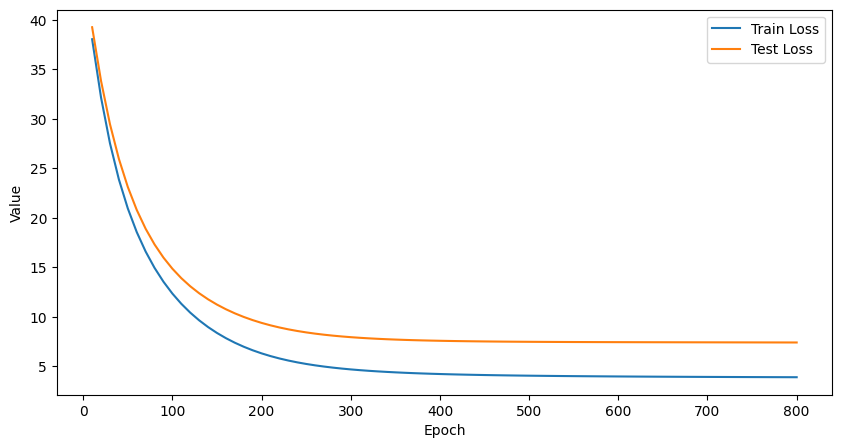

In [39]:
plt.figure(figsize=(10, 5))

plt.plot(epoch_num, train_losses, label='Train Loss')
plt.plot(epoch_num, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [40]:
print(calc_mae(pred, test, test_mask))
print(calc_mse(pred, test, test_mask))

tensor(1.8199, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(5.6352, dtype=torch.float64)


In [10]:
# The baseline prediction is the mean rating, which is zero
baseline_prediction = 0

# Create a tensor of the same shape as test, filled with the baseline prediction
baseline_full = torch.full_like(test, baseline_prediction)
baseline_full = baseline_full.T
# Calculate baseline errors only for non-masked entries in test set
baseline_mse = calc_mse(baseline_full, test, test_mask)
baseline_mae = calc_mae(baseline_full, test, test_mask)

print(
    f"Baseline MSE: {baseline_mse.item():.4f}, Baseline MAE: {baseline_mae.item():.4f}")

Baseline MSE: 7.4633, Baseline MAE: 2.1265


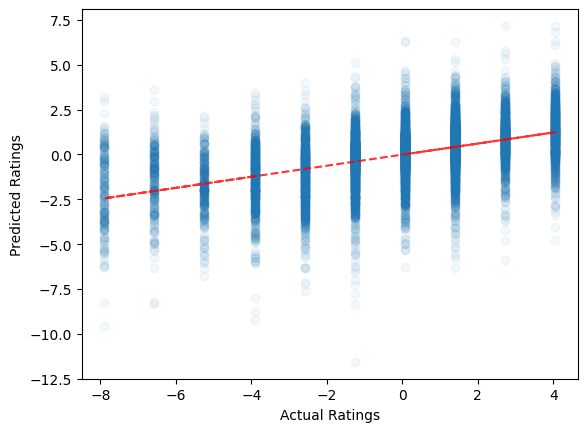

In [22]:

# visualize the model predictions vs the actual ratings on the test set. Plot only the non-zero ratings.
pred = model()
pred_np = pred.T.detach().numpy()
test_np = test.detach().numpy()
y = []
y_pred = []
for i in range(test_np.shape[0]):
    for j in range(test_np.shape[1]):
        if test_mask[i, j]:
            y.append(test_np[i, j])
            y_pred.append(pred_np[i, j])

# Convert lists to numpy arrays for fitting
y = np.array(y)
y_pred = np.array(y_pred)
def plot_scatter(y, y_pred):
    # Calculate the best fit line
    z = np.polyfit(y, y_pred, 1)
    p = np.poly1d(z)
    plt.scatter(y, y_pred, alpha=0.05)
    plt.plot(y, p(y), "r--", alpha=0.8)  # Add the best fit line in red
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')

    plt.show()

plot_scatter(y, y_pred)


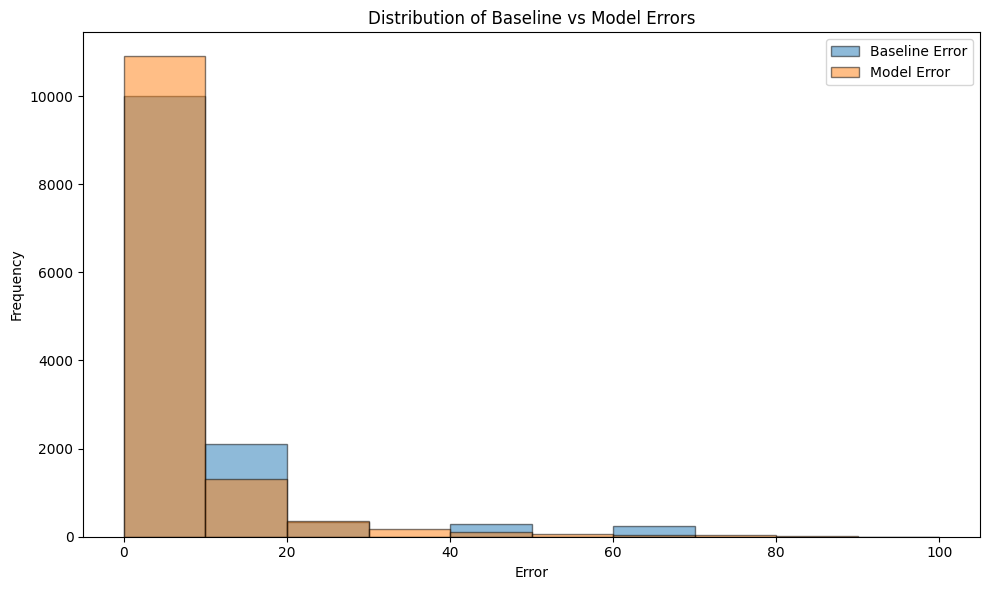

In [23]:
def plot_error_distributions(y, y_pred):
    # Calculate errors (residuals)
    errors = (y_pred - y)**2
    baseline_error = (0-y)**2

    plt.figure(figsize=(10, 6))

    # Plot both histograms on the same axes with transparency, ensuring 10 buckets evenly distributed from 0 to 100
    plt.hist(baseline_error, bins=np.linspace(0, 100, 11), alpha=0.5,
             label='Baseline Error', edgecolor='black')
    plt.hist(errors, bins=np.linspace(0, 100, 11), alpha=0.5, label='Model Error', edgecolor='black')

    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Baseline vs Model Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_error_distributions(y, y_pred)

## Second Model

In [24]:
# format the train and test data to be used in the mode. 
# X_train and X_test are tensors of shape (num_ratings, 2) where the first column is the movie index and the second column is the user index.
# y_train and y_test are tensors of shape (num_ratings, 1) where the first column is the rating.
train_indices = torch.nonzero(train_mask)
test_indices = torch.nonzero(test_mask)


# Create X_train and X_test
X_train = train_indices  # Shape: (num_ratings, 2) with [movie_idx, user_idx]
X_test = test_indices    # Shape: (num_ratings, 2) with [movie_idx, user_idx]

# Create y_train and y_test
y_train = train[train_mask.bool()]  # Shape: (num_ratings,)
y_test = test[test_mask.bool()]     # Shape: (num_ratings,)

# Reshape y_train and y_test to have shape (num_ratings, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([26270, 2])
X_test shape: torch.Size([12978, 2])
y_train shape: torch.Size([26270, 1])
y_test shape: torch.Size([12978, 1])


In [41]:

class Model2(nn.Module):
    def __init__(self, num_users, num_movies, num_features):
        super().__init__()
        self.movie_embedding = nn.Embedding(num_movies, num_features)
        self.user_embedding = nn.Embedding(num_users, num_features)
        self.linear = nn.Sequential(
            nn.Linear(num_features*2, 10),
            nn.Linear(10, 1)
        )


    def forward(self, x): # x is a tensor of shape (batch_size, 2)
        movie_embedding = self.movie_embedding(x[:, 0])
        user_embedding = self.user_embedding(x[:, 1])
        combined = torch.cat([movie_embedding, user_embedding], dim=1)
        output = self.linear(combined)
        return output


num_users = df.shape[1]
num_features = 10  # the size of vectors for users and movies
num_movies = df.shape[0]

model2 = Model2(num_users, num_movies, num_features)

optimizer = optim.Adam(model2.parameters(), lr=0.01)

def loss_function(pred, target, lambda_reg=0.001):
    reg_loss = 0
    
    for param in model2.parameters():
        if param.requires_grad:  # Only include trainable parameters
            reg_loss += torch.sum(param ** 2)
    pred_error = torch.sum((pred - target)**2) / pred.shape[0]
    total_loss = pred_error + lambda_reg/2 * reg_loss
    return total_loss

def calc_mse(pred, target):
    with torch.no_grad():
        return torch.mean((pred - target)**2)

def calc_mae(pred, target):
    with torch.no_grad():
        return torch.mean(torch.abs(pred - target))
    




In [42]:
# model performance before training
pred = model2(X_test)
mse = calc_mse(pred, y_test)
print('before training: MSE=', mse.item())
mae_ = calc_mae(pred, y_test)
print('before training: MAE=', mae_.item())



before training: MSE= 7.5903114360892205
before training: MAE= 2.1567443201437033


Epoch 10, Loss: 29.8210, Train Loss: 29.4262, Test Loss: 29.5356
Epoch 20, Loss: 26.0653, Train Loss: 25.7151, Test Loss: 25.8541
Epoch 30, Loss: 22.7774, Train Loss: 22.4764, Test Loss: 22.6386
Epoch 40, Loss: 20.0017, Train Loss: 19.7518, Test Loss: 19.9557
Epoch 50, Loss: 17.7020, Train Loss: 17.4944, Test Loss: 17.7635
Epoch 60, Loss: 15.7735, Train Loss: 15.5970, Test Loss: 15.9570
Epoch 70, Loss: 14.1196, Train Loss: 13.9667, Test Loss: 14.4417
Epoch 80, Loss: 12.6793, Train Loss: 12.5454, Test Loss: 13.1519
Epoch 90, Loss: 11.4138, Train Loss: 11.2957, Test Loss: 12.0597
Epoch 100, Loss: 10.2972, Train Loss: 10.1930, Test Loss: 11.1440
Epoch 110, Loss: 9.3095, Train Loss: 9.2172, Test Loss: 10.3813
Epoch 120, Loss: 8.4373, Train Loss: 8.3563, Test Loss: 9.7676
Epoch 130, Loss: 7.6782, Train Loss: 7.6086, Test Loss: 9.2822
Epoch 140, Loss: 7.0356, Train Loss: 6.9776, Test Loss: 8.8885
Epoch 150, Loss: 6.5036, Train Loss: 6.4560, Test Loss: 8.5656
Epoch 160, Loss: 6.0664, Train Lo

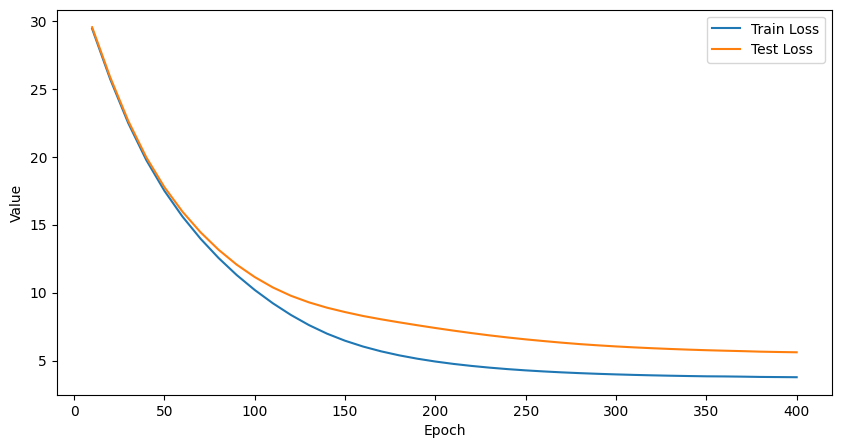

In [43]:
# train the model

model2.train()
losses = []
train_losses = []
test_losses = []
epoch_num = []
train_loss_values = []
test_loss_values = []
for epoch in range(400):
    optimizer.zero_grad()
    pred = model2(X_train)
    loss = loss_function(pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        model2.eval()
        train_loss = loss_function(model2(X_train), y_train)
        test_loss = loss_function(model2(X_test), y_test)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_loss_values.append(train_loss.item())
        test_loss_values.append(test_loss.item())
        epoch_num.append(epoch+1)
        print(
            f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
print('after training: Loss= ', loss_function(model2(X_test), y_test).item())
print('after training: MSE= ', calc_mse(model2(X_test), y_test).item())
print('after training: MAE= ', calc_mae(model2(X_test), y_test).item())
model2.train()

# Plotting the loss as a function of epoch

plt.figure(figsize=(10, 5))

plt.plot(epoch_num, train_loss_values, label='Train Loss')
plt.plot(epoch_num, test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

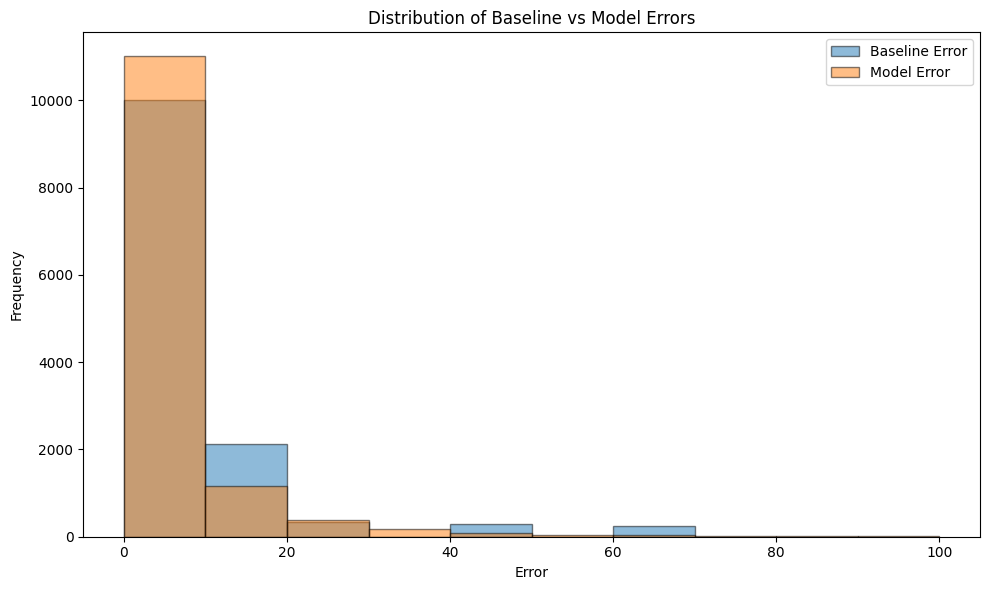

In [44]:
# histogram of the errors
y_test_np = y_test.detach().numpy()
pred_np = model2(X_test).detach().numpy()
plot_error_distributions(y_test_np, pred_np)
